In [1]:
import decimal

import matplotlib.pyplot as plt
import numpy
import pandas as pd
import scipy.sparse
import scipy.special
import scipy.stats
import tqdm

In [2]:
import hetmech.hetmat
import hetmech.degree_group
import hetmech.degree_weight
import hetmech.pipeline

In [3]:
hetmat = hetmech.hetmat.HetMat('../data/hetionet-v1.0.hetmat/')

In [4]:
metapaths = ['DaGbC', 'SpDpS', 'SEcCrCtD',]

In [5]:
# Used in the next cell
def matrix_to_dgp(matrix, dwpc_scaler, source_degree_to_ind, target_degree_to_ind):
    rows = dict()
    if scipy.sparse.issparse(matrix):
        matrix = matrix.toarray()
    
    for source_degree, row_inds in source_degree_to_ind.items():
        row_matrix = matrix[row_inds, :]
        for target_degree, col_inds in target_degree_to_ind.items():
            if source_degree == 0 or target_degree == 0:
                continue
            slice_matrix = row_matrix[:, col_inds]
            values = numpy.arcsinh(slice_matrix / dwpc_scaler)
            rows[(source_degree, target_degree)] = values.flatten().tolist()
    return rows

In [6]:
def metapath_to_full_dgp(hetmat, metapath):
    _, _, pc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, dense_threshold=0.7, damping=0.0)
    _, _, dwpc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, dense_threshold=0.7, damping=0.5)
    scaler = dwpc_matrix.mean()

    source_degree_to_ind, target_degree_to_ind = hetmech.degree_group.metapath_to_degree_dicts(hetmat, metapath)

    perm_dgp = None
    for name, permat in tqdm.tqdm(hetmat.permutations.items()):
        _, _, matrix = hetmech.degree_weight.dwpc(permat, metapath, damping=0.5, dense_threshold=0.7)
        degree_to_dgp = matrix_to_dgp(matrix, scaler, source_degree_to_ind, target_degree_to_ind)
        if perm_dgp is None:
            perm_dgp = degree_to_dgp.copy()
        else:
            for degree_combo, dgp_list in perm_dgp.items():
                dgp_list.extend(degree_to_dgp[degree_combo])
    return perm_dgp

In [7]:
# # Check that all the computed mean, sd are within tolerable range of the statistics-computed values
# import statistics
# import pytest

# for degree_combo, dgp_values in perm_dgp.items():
#     dgp_values = numpy.array(dgp_values)
#     stat_mean_nz = statistics.mean(dgp_values[dgp_values > 0])
#     try:
#         stat_sd_nz = statistics.stdev(dgp_values[dgp_values > 0])
#     except statistics.StatisticsError:
#         continue        

#     dwpc_sum = numpy.sum(dgp_values)
#     dwpc_sum_sq = numpy.sum([i**2 for i in dgp_values])
#     nnz = len(dgp_values[dgp_values > 0])
#     mean_nz = dwpc_sum / nnz
#     sd_nz = ((dwpc_sum_sq - (dwpc_sum**2) / nnz) / (nnz - 1)) ** 0.5

#     assert mean_nz == pytest.approx(stat_mean_nz, abs=1e-7)
#     assert sd_nz == pytest.approx(stat_sd_nz, abs=1e-7)

In [8]:
class GammaHurdle:
    def __init__(self):
        self.alpha = None
        self.beta = None
        self._gamma_coef = None
        self._p_nnz = None
    
    def fit(self, values):
        values = numpy.array(values)
        dwpc_sum = numpy.sum(values)
        dwpc_sum_sq = numpy.sum([i**2 for i in values])
        nnz = len(values[values > 0])
        mean_nz = dwpc_sum / nnz
        sd_nz = ((dwpc_sum_sq - (dwpc_sum**2) / nnz) / (nnz - 1)) ** 0.5
        self.beta = mean_nz / sd_nz ** 2
        self.alpha = mean_nz * self.beta
        self._gamma_coef = (self.beta ** self.alpha) / scipy.special.gamma(self.alpha)
        self._p_nnz = nnz / len(values)
        
    def pdf(self, x):
        return self._p_nnz * self._gamma_coef * (x ** (self.alpha - 1)) * numpy.exp(- self.beta * x)
    
    def cdf(self, x):
        return (1 - self._p_nnz) + self._p_nnz * scipy.special.gammainc(self.alpha, self.beta * x)

In [9]:
def check_fit(values):
    g = GammaHurdle()
    g.fit(values)

    x = numpy.linspace(0, 10, 100)
    y = [g.pdf(i) for i in x]

    values = numpy.array(values)
    values_nz = values[values > 0]
    plt.figure()
    plt.plot(x, y, linewidth=2, label='gamma fit')
    bars, _, _ = plt.hist(values, density=True, label='true dist')
    plt.legend()
    plt.ylim((0, 1.1 * max(bars[1:])));
    
    return scipy.stats.kstest(values_nz, 'gamma', args=(g.alpha, 0, 1/g.beta))

100%|██████████| 200/200 [01:07<00:00,  2.97it/s]


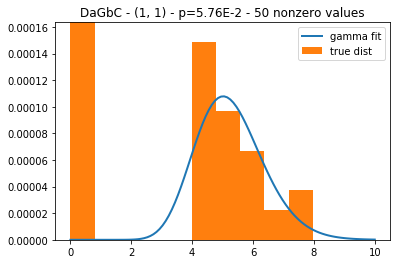

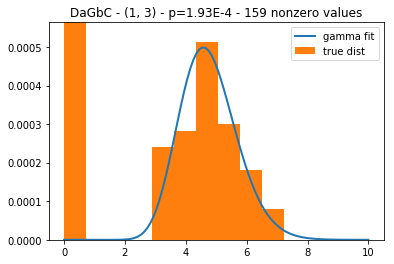

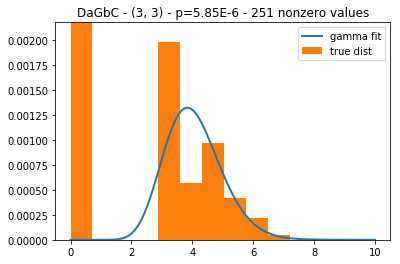

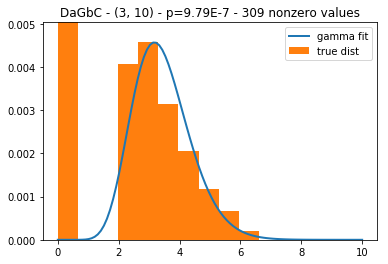

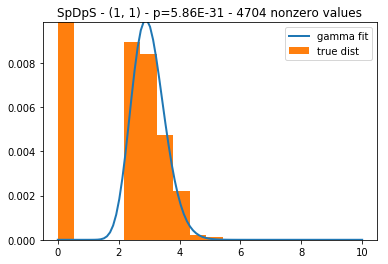

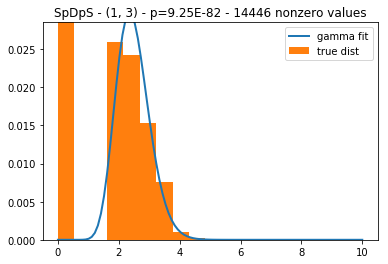

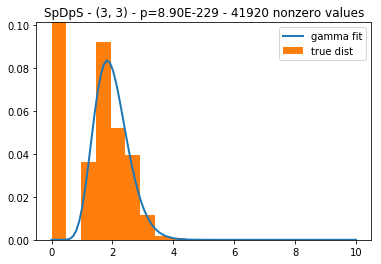

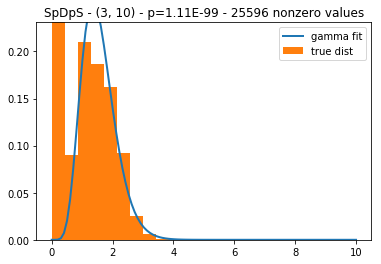

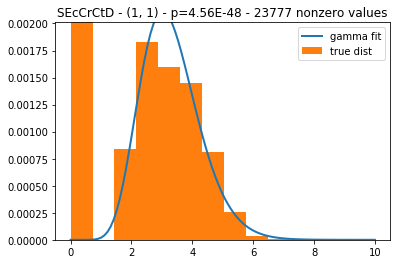

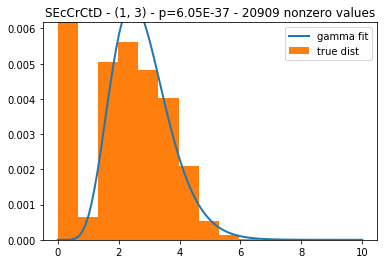

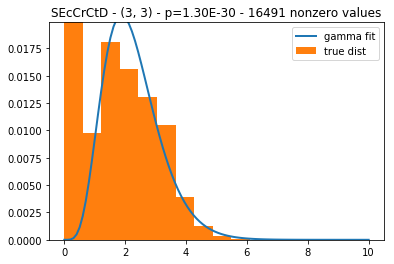

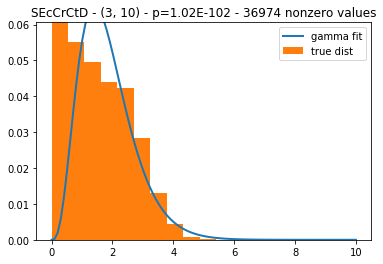

In [10]:
for metapath in metapaths:
    perm_dgp = metapath_to_full_dgp(hetmat, metapath)
    for degree_combo in [(1,1), (1,3), (3,3), (3, 10),]:
        dgp_values = perm_dgp[degree_combo]
        values_nz = [i for i in dgp_values if i > 0]
        ks_result = check_fit(dgp_values)

        p_value = decimal.Decimal(ks_result[1])
        plt.title(f'{metapath} - {degree_combo} - p={p_value :.2E} - {len(values_nz)} nonzero values')

In [11]:
values_nz = [i for i in dgp_values if i > 0]

In [12]:
distribution_performance = dict()

for distribution in tqdm.tqdm([
    scipy.stats.alpha,
    scipy.stats.anglit,
    scipy.stats.arcsine,
    scipy.stats.beta,
    scipy.stats.betaprime,
    scipy.stats.bradford,
    scipy.stats.burr,
    scipy.stats.burr12,
    scipy.stats.cauchy,
    scipy.stats.chi,
    scipy.stats.chi2,
    scipy.stats.cosine,
    scipy.stats.dgamma,
    scipy.stats.dweibull,
#     scipy.stats.erlang,
    scipy.stats.expon,
    scipy.stats.exponnorm,
    scipy.stats.exponweib,
    scipy.stats.exponpow,
    scipy.stats.f,
    scipy.stats.fatiguelife,
    scipy.stats.fisk,
    scipy.stats.foldcauchy,
    scipy.stats.foldnorm,
#     scipy.stats.frechet_r,
#     scipy.stats.frechet_l,
    scipy.stats.genlogistic,
    scipy.stats.gennorm,
    scipy.stats.genpareto,
    scipy.stats.genexpon,
    scipy.stats.genextreme,
    scipy.stats.gausshyper,
    scipy.stats.gamma,
    scipy.stats.gengamma,
    scipy.stats.genhalflogistic,
    scipy.stats.gilbrat,
    scipy.stats.gompertz,
    scipy.stats.gumbel_r,
    scipy.stats.gumbel_l,
    scipy.stats.halfcauchy,
    scipy.stats.halflogistic,
    scipy.stats.halfnorm,
    scipy.stats.halfgennorm,
    scipy.stats.hypsecant,
    scipy.stats.invgamma,
    scipy.stats.invgauss,
    scipy.stats.invweibull,
    scipy.stats.johnsonsb,
    scipy.stats.johnsonsu,
    scipy.stats.kappa4,
    scipy.stats.kappa3,
    scipy.stats.ksone,
    scipy.stats.kstwobign,
    scipy.stats.laplace,
    scipy.stats.levy,
    scipy.stats.levy_l,
    scipy.stats.levy_stable,
    scipy.stats.logistic,
    scipy.stats.loggamma,
    scipy.stats.loglaplace,
    scipy.stats.lognorm,
    scipy.stats.lomax,
    scipy.stats.maxwell,
    scipy.stats.mielke,
    scipy.stats.nakagami,
    scipy.stats.ncx2,
    scipy.stats.ncf,
    scipy.stats.nct,
    scipy.stats.norm,
    scipy.stats.pareto,
    scipy.stats.pearson3,
    scipy.stats.powerlaw,
    scipy.stats.powerlognorm,
    scipy.stats.powernorm,
    scipy.stats.rdist,
    scipy.stats.reciprocal,
    scipy.stats.rayleigh,
    scipy.stats.rice,
    scipy.stats.recipinvgauss,
    scipy.stats.semicircular,
    scipy.stats.skewnorm,
    scipy.stats.t,
    scipy.stats.trapz,
    scipy.stats.triang,
    scipy.stats.truncexpon,
    scipy.stats.truncnorm,
    scipy.stats.tukeylambda,
    scipy.stats.uniform,
    scipy.stats.vonmises,
    scipy.stats.vonmises_line,
    scipy.stats.wald,
    scipy.stats.weibull_min,
    scipy.stats.weibull_max,
    scipy.stats.wrapcauchy
]):
    try:
        params = distribution.fit(values_nz)
        ks, p = scipy.stats.kstest(values_nz, distribution.cdf, args=params)
        distribution_performance[distribution] = (ks, p)
    except:
        continue

  0%|          | 0/91 [00:00<?, ?it/s]/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
  2%|▏         | 2/91 [00:00<00:42,  2.07it/s]/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:312: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))
  4%|▍         | 4/91 [00:02<00:52,  1.67it/s]/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:589: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:593: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: in

In [13]:
model_df = pd.DataFrame.from_dict(distribution_performance, orient='index')

In [17]:
model_df.sort_values(by=1, ascending=False).head(5)

,0,1
<scipy.stats._continuous_distns.exponweib_gen object at 0x7f693b3c2588>,0.019945,3.357472e-13
<scipy.stats._continuous_distns.gengamma_gen object at 0x7f693b3ecef0>,0.020486,6.654501e-14
<scipy.stats._continuous_distns.exponpow_gen object at 0x7f693b3c2be0>,0.021329,4.914416e-15
<scipy.stats._continuous_distns.gompertz_gen object at 0x7f693b37a438>,0.026101,2.640552e-22
<scipy.stats._continuous_distns.gausshyper_gen object at 0x7f693b3808d0>,0.026233,1.586766e-22


100%|██████████| 200/200 [00:14<00:00, 13.72it/s]


KstestResult(statistic=0.5494956784587973, pvalue=0.0)


Text(0.5,1,'SpDpS - (3, 3) - p=0.00E+2 - 41920 nonzero values')

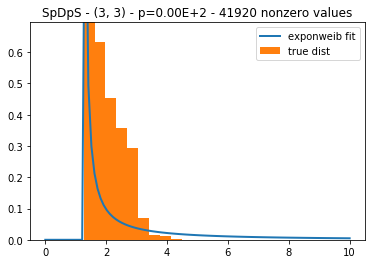

In [15]:
metapath = metapaths[1]
degree_combo = (3,3)
dist = scipy.stats.exponweib

perm_dgp = metapath_to_full_dgp(hetmat, metapath)

dgp_values = perm_dgp[degree_combo]
values_nz = [i for i in dgp_values if i > 0]

params = dist.fit(values_nz)

ks_result = scipy.stats.kstest(values_nz, dist.cdf, args=params)
print(ks_result)

x = numpy.linspace(0, 10, 100)
y = [dist.pdf(i, *params) for i in x]

plt.figure()
plt.plot(x, y, linewidth=2, label='exponweib fit')
bars, _, _ = plt.hist(values_nz, density=True, label='true dist')
plt.legend()
plt.ylim((0, 1.1 * max(bars[1:])));

p_value = decimal.Decimal(ks_result[1])
plt.title(f'{metapath} - {degree_combo} - p={p_value :.2E} - {len(values_nz)} nonzero values')

Text(0.5,1,'SpDpS - (3, 3) - p=8.90E-229 - 41920 nonzero values')

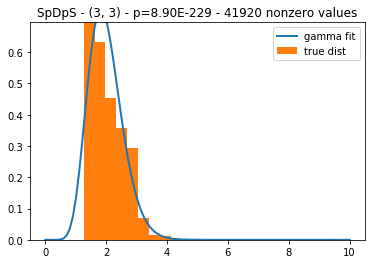

In [16]:
g = GammaHurdle()
g.fit(values_nz)
ks_result = scipy.stats.kstest(values_nz, g.cdf)
ks_result

x = numpy.linspace(0, 10, 100)
y = g.pdf(x)

plt.figure()
plt.plot(x, y, linewidth=2, label='gamma fit')
bars, _, _ = plt.hist(values_nz, density=True, label='true dist')
plt.legend()
plt.ylim((0, 1.1 * max(bars[1:])));

p_value = decimal.Decimal(ks_result[1])
plt.title(f'{metapath} - {degree_combo} - p={p_value :.2E} - {len(values_nz)} nonzero values')